In this assignment you'll have to explore and classify time series. The dataset is [FordA](http://www.timeseriesclassification.com/description.php?Dataset=FordA), which is a set of recordings of engine noise under typical conditions and you need to classify if certain condition exists.

In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting improts
import seaborn as sns

In [3]:
# Generic imports
import pathlib

# DS imports
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

## Constants

In [4]:
DATA_DIR = pathlib.Path("data/")
DATASET = "FordA"

# Loading the data

Data files are stored in tabular format:

In [5]:
!head -n 2 data/FordA/FordA_TRAIN.txt

  -1.0000000e+00  -7.9717168e-01  -6.6439208e-01  -3.7301463e-01   4.0815121e-02   5.2693599e-01   9.8428794e-01   1.3531202e+00   1.5781078e+00   1.6592509e+00   1.6408093e+00   1.5522896e+00   1.4379516e+00   1.2793537e+00   1.0691193e+00   7.4454700e-01   2.7760541e-01  -3.0072351e-01  -9.3732792e-01  -1.5200828e+00  -1.9516165e+00  -2.1360326e+00  -2.0401363e+00  -1.7229406e+00  -1.2619003e+00  -8.0454833e-01  -4.6153436e-01  -2.7822475e-01  -2.5130000e-01  -3.0183001e-01  -3.1326381e-01  -2.0445830e-01   6.7002208e-02   4.7161115e-01   9.3265143e-01   1.3531202e+00   1.6444976e+00   1.7588356e+00   1.6961341e+00   1.4822114e+00   1.1797690e+00   8.2569008e-01   4.4948122e-01   7.2534692e-02  -2.9703519e-01  -6.4595047e-01  -9.7421115e-01  -1.2508353e+00  -1.4094332e+00  -1.4278748e+00  -1.3024718e+00  -1.0627309e+00  -7.4922349e-01  -4.1727450e-01  -1.0745543e-01   1.6879990e-01   3.9784471e-01   5.7488417e-01   6.8553384e-01   7.1872874e-01   6.7815720e-01   5.4906592e-01   3.325

In [6]:
train = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TRAIN.txt"),
                    header=None,
                    sep="\s+",
                    skipinitialspace=True)
test = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TEST.txt"),
                   header=None,
                   sep="\s+",
                   skipinitialspace=True)

In [7]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


So, each row represents a single measurement, with column `0` being class label, and columns `1-501` being measured values. Let's check missing values:

In [8]:
train.notnull().sum(axis=1).unique()

array([501])

In [9]:
test.notnull().sum(axis=1).unique()

array([501])

Let's change column names to something meaningful:

In [10]:
train.rename({0: "label"}, axis=1, inplace=True)
test.rename({0: "label"}, axis=1, inplace=True)

In [11]:
train.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)
test.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)

We can now select data values by filtering:

In [12]:
train.filter(like="val_")

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.715205,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.463329,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.902821,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.268671,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709


The dataset is almost balanced:

In [13]:
train.iloc[:, 0].value_counts()

-1.0    1846
 1.0    1755
Name: label, dtype: int64

In [14]:
test.iloc[:, 0].value_counts()

-1.0    681
 1.0    639
Name: label, dtype: int64

# Task 1: explore time series

In this task you need to plot data samples with class label designation. Consider 10 or 20 random samples, and create a `2 x 5` or `4 x 5` plot, with eash subplot being the data records (i. e. `train.filter(like="val_").iloc[<sample_idx>]`), subtitles displaying sample index and class label. You can use color as well.

In [15]:
N_SAMPLES = 20
N_COLS = 5
N_ROWS = 20 // N_COLS

samples = train.sample(N_SAMPLES, replace=False)

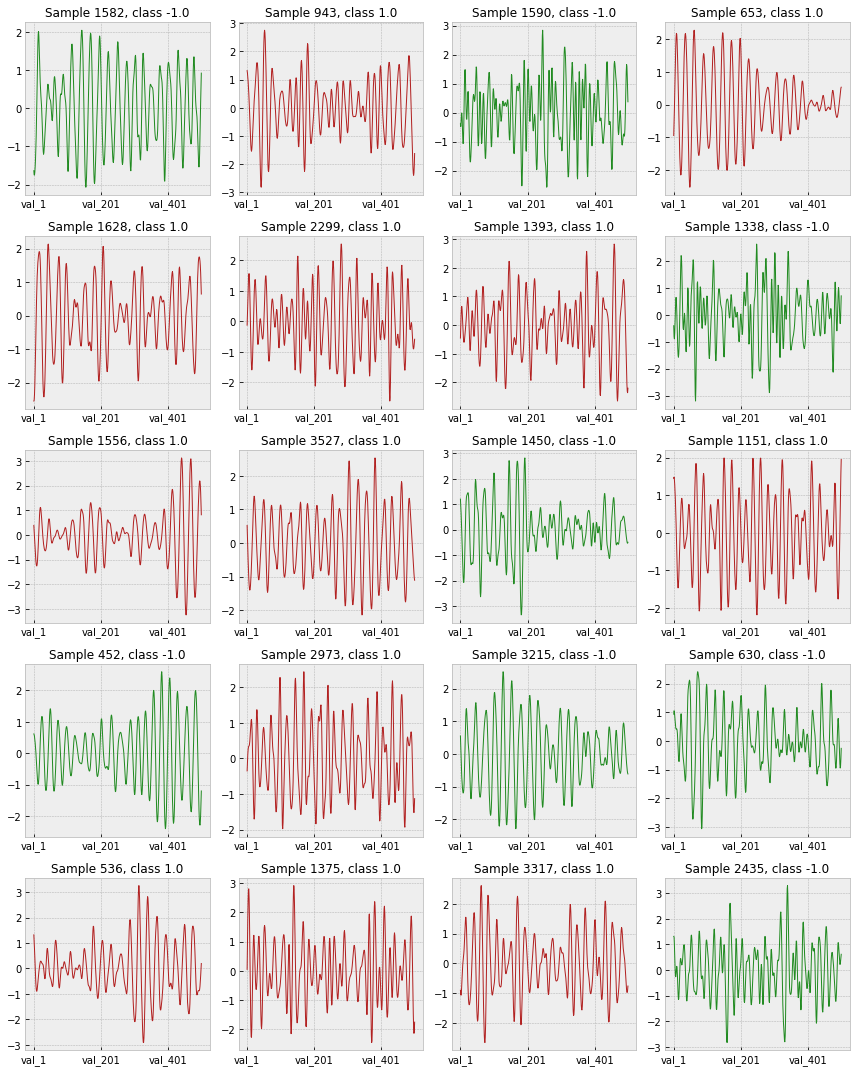

In [16]:
plt.figure(figsize=(3 * N_ROWS, 3 * N_COLS))

for si, (sidx, sample) in enumerate(samples.iterrows()):
    sample_class = sample.iloc[0]
    sample_series = sample.iloc[1:]

    ax = plt.subplot(5, 4, si + 1)
    sample_series.plot(linewidth=1, c="firebrick" if sample_class==1 else "forestgreen", ax=ax)
    plt.title(f"Sample {sidx}, class {sample_class}", fontsize=12)

plt.tight_layout();

# Task 2: explore statistics

In this task you need to plot simple statistics for each class, i. e. calculate `mean`, `median`, `std` and other statistics (of your choice) for each row and then visualize them in such a way, that one can figure out if a distribution of a given statistics differs between class `1` and `-1`.

**Hint:** you can consider [violin plots](https://seaborn.pydata.org/examples/grouped_violinplots.html) or [scatter plot matrix](https://seaborn.pydata.org/examples/scatterplot_matrix.html) helpful.

## Example: median

In [17]:
train["data_median"] = train.filter(like="val_").median(axis=1)
test["data_median"] = test.filter(like="val_").median(axis=1)

The simplest visualization possible (you need to create smth more elaborated):

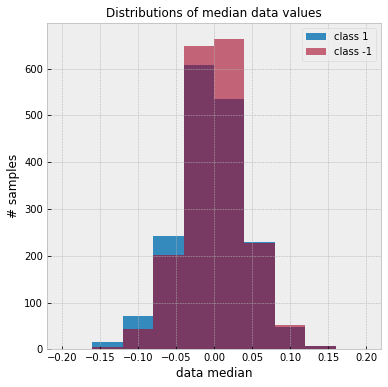

In [18]:
train.loc[train["label"]==1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), label="class 1")
train.loc[train["label"]==-1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("data median")
plt.ylabel("# samples")
plt.title("Distributions of median data values", fontsize=12);

**Note:** we can easily check if median is a good feature with ROC curve and score (as they do not rely on any specific normalization of the "predicted" probabilities). Think on why we're using `-data_median`.

In [19]:
fpr, tpr, thr = roc_curve(train["label"], -train["data_median"])

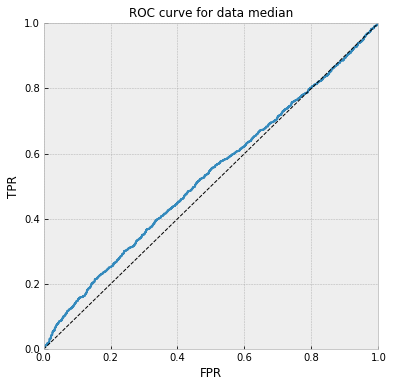

In [20]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data median", fontsize=12);

Ok, median contains *some* information (i. e. looking at median values is better than random classifier), but cannot serve as a *single* feature.

## Exploration

### Mean and standard deviation

If you try to calculate mean and standard deviation, you'll quickly realize, that data was whitened, hence, neither mean, nor `std` can help in classification (your goal was to figure this out):

In [21]:
train.filter(like="val_").mean(axis=1).describe()  # practically speaking, ~1e-11 is 0

count    3.601000e+03
mean    -2.323195e-11
std      8.135258e-10
min     -7.743400e-09
25%     -5.184000e-10
50%     -1.759999e-11
75%      4.742800e-10
max      5.187620e-09
dtype: float64

In [22]:
train.filter(like="val_").std(axis=1).describe()

count    3.601000e+03
mean     1.000000e+00
std      1.234783e-09
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

### Skew and curtosis

Just in case, we check other statistics, which do not suffer from whitening (given that data distribution is not Gaussian, of course):

In [23]:
for feature in ["skew", "kurtosis"]:
    train[f"data_{feature}"] = train.filter(like="val_").apply(feature, axis=1)
    test[f"data_{feature}"] = test.filter(like="val_").apply(feature, axis=1)

To plot median, skeweness and kurtosis on the same violin plot with class designation, we'll do some trickery:

In [24]:
train.filter(like="data_").stack().reset_index(level=1).rename({"level_1": "feature", 0: "value"}, axis=1)

,feature,value
0,data_median,-0.030960
0,data_skew,0.076155
0,data_kurtosis,-0.860876
1,data_median,0.035526
1,data_skew,-0.019140
...,...,...
3599,data_skew,-0.074699
3599,data_kurtosis,-0.719546
3600,data_median,-0.030453
3600,data_skew,0.024203


In [25]:
train_stacked = (train
                 .filter(like="data_")
                 .stack()
                 .reset_index(level=1)
                 .rename({"level_1": "feature", 0: "value"}, axis=1))
train_stacked = train_stacked.join(train["label"])
train_stacked

,feature,value,label
0,data_median,-0.030960,-1.0
0,data_skew,0.076155,-1.0
0,data_kurtosis,-0.860876,-1.0
1,data_median,0.035526,1.0
1,data_skew,-0.019140,1.0
...,...,...,...
3599,data_skew,-0.074699,1.0
3599,data_kurtosis,-0.719546,1.0
3600,data_median,-0.030453,-1.0
3600,data_skew,0.024203,-1.0


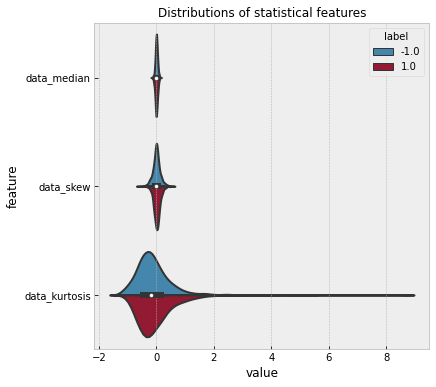

In [26]:
sns.violinplot(data=train_stacked,
               x="value", y="feature",
               hue="label", split=True)
plt.title("Distributions of statistical features", fontsize=12);

Pair plot provides somewhat different prospective (and given very different scales of the features - it's a bit more readable):

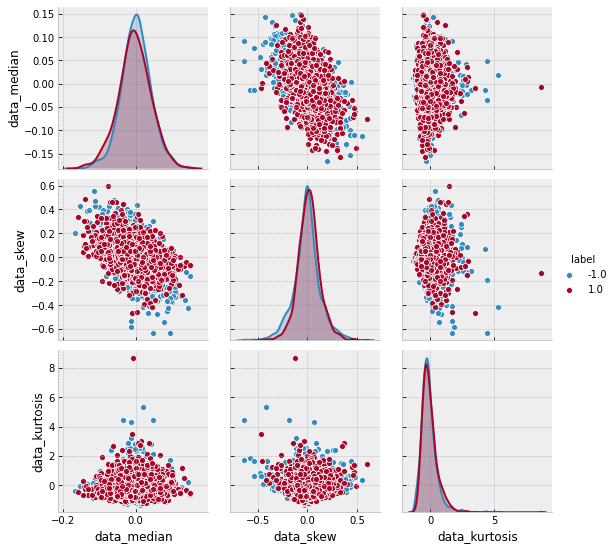

In [27]:
sns.pairplot(train[["label", "data_median", "data_skew", "data_kurtosis"]], hue="label");

These features do not seem to be very important, but we need to ensure they're really not:

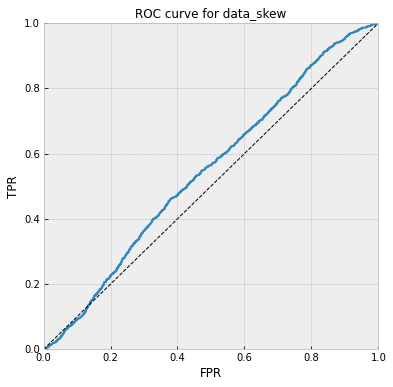

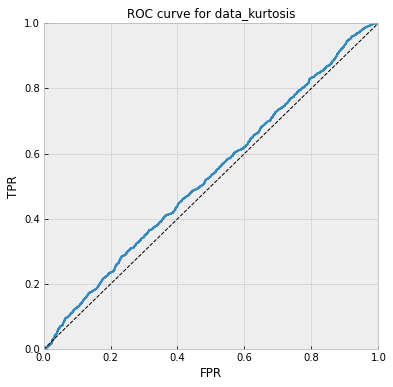

In [28]:
for feature in ["data_skew", "data_kurtosis"]:
    fpr, tpr, thr = roc_curve(train["label"], train[feature])

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC curve for {feature}", fontsize=12);
    plt.show()

Ok, these features are quite weak, but not completely useless, we'll keep them.

# Task 3: explore advanced features

In this task you need to calculate and analyze other time series features. Think on which features in time/frequency domains may be useful for a classification of the dataset.

**Hint:** try various features from [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

## Example: 0-crossings

For this features we'll not use `tsfresh`, and will do some ninja stuff in Pandas itself:

**Step 1:** mask on `> 0`.

In [29]:
mask = (train.filter(like="val_") > 0).astype(int)
mask

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,1,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,0
3597,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3598,0,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,0
3599,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0


**Step 2:** calc `diff` to get crossings (from `< 0` to `> 0`, or other way around).

In [30]:
mask.diff(axis=1) == 1  # crossing from -0 to +0

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3597,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3598,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3599,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
mask.diff(axis=1) == -1  # crossing from +0 to -0

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3597,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3598,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3599,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


**Step 3:** calculate counts.

In [32]:
train["zero+"] = (mask.diff(axis=1) == 1).sum(axis=1)
train["zero-"] = (mask.diff(axis=1) == -1).sum(axis=1)

In [33]:
train["zero+"]

0       18
1       19
2       17
3       22
4       34
        ..
3596    21
3597    21
3598    32
3599    21
3600    20
Name: zero+, Length: 3601, dtype: int64

**Note:** we do not need to perform any normalization, as all samples have the same length.

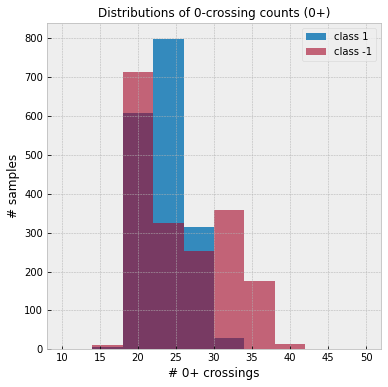

In [34]:
train.loc[train["label"]==1, "zero+"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero+"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0+ crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0+)", fontsize=12);

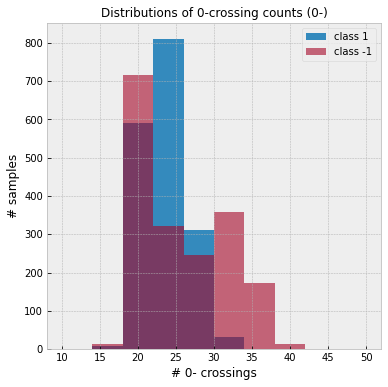

In [35]:
train.loc[train["label"]==1, "zero-"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero-"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0- crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0-)", fontsize=12);

Of course, for oscillatory time series `zero+` and `zero-` are highly correlated, so we may drop one of them:

In [36]:
train.filter(like="zero").corr()

,zero+,zero-
zero+,1.000000,0.988801
zero-,0.988801,1.000000


In [37]:
train.drop("zero-", axis=1, inplace=True)

The distribution of `zero+` looks fancy, and ROC curve reflects that:

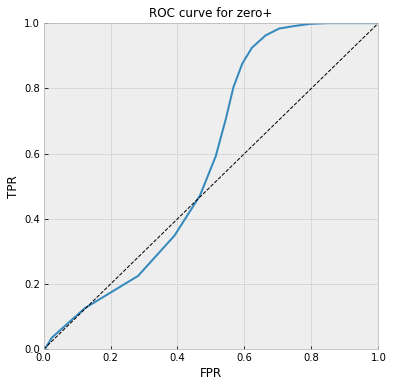

In [38]:
fpr, tpr, thr = roc_curve(train["label"], -train["zero+"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for zero+", fontsize=12);

Think on this in the following way.

Look at the histograms, and perform an estimate (no code, just in your head): given, that `zero+` is equal to `v`, what is the probability of a sample to belong to class `1`? Is this probability monotonic with `v`? How does this influence the choice of the model? Will logistic regression do the job here?

## Exploration

So far, we have the following features:

- `data_median`, 
- `data_skew`, 
- `data_kurtosis`, 
- `zero+`.

Let's add some other features inspired by `tsfresh`. We'll calculate all of them manually, so that you know how to do that without blindly relying on `tsfresh`.

First, samples of class `1` seem less regular, hence, we can try to estimate

1. how regular are the deltas, i.e. `x(i) - x(i-1)`,
2. how periodic each sample is.

The deltas:

In [39]:
for feature in ["mean", "median", "std"]:
    train[f"diff_{feature}"] = train.filter(like="val_").diff(axis=1).apply(feature, axis=1)
    test[f"diff_{feature}"] = test.filter(like="val_").diff(axis=1).apply(feature, axis=1)

In [40]:
train.filter(like="diff_")

,diff_mean,diff_median,diff_std
0,-0.001537,-0.003688,0.244480
1,-0.002252,0.004367,0.244646
2,-0.000947,0.003146,0.226139
3,0.000710,-0.006676,0.268913
4,-0.000863,0.031278,0.428676
...,...,...,...
3596,-0.005611,0.000592,0.262849
3597,-0.000873,0.005676,0.286104
3598,0.000600,0.033700,0.392914
3599,-0.004584,-0.010484,0.262521


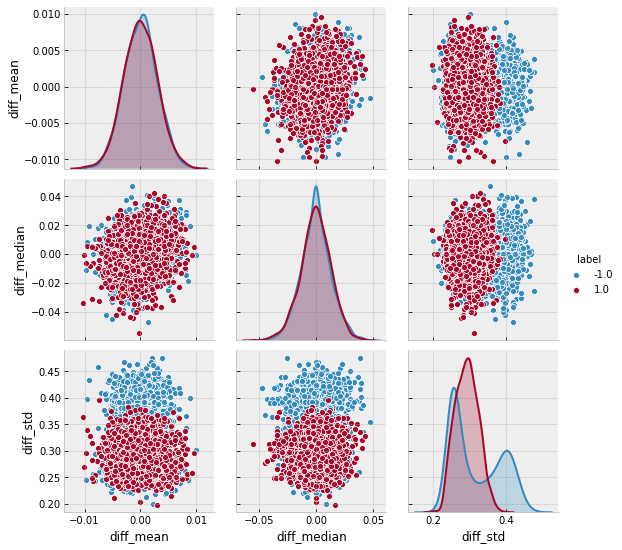

In [41]:
sns.pairplot(train[["label", "diff_mean", "diff_median", "diff_std"]], hue="label");

Great, `diff_std` seems to be a strong feature! Let's check if it's and independent one, or it's correlated with 0-crossing, which is a good feature on it's own:

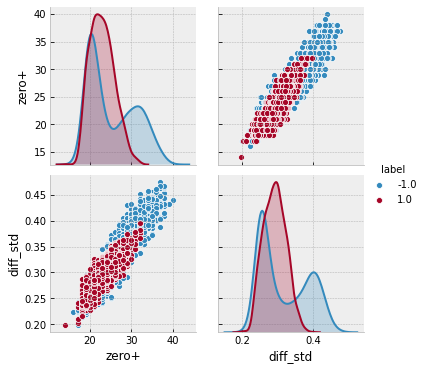

In [42]:
sns.pairplot(train[["label", "zero+", "diff_std"]], hue="label");

They are correlated (ungraded: think on why is it, and how you can estimate their relation), unfortunately. But, we'll keep both for now.

Next, we'll look at some Fourier features. Although, plain and simple FFT can be used here, we'll use Welch transform varioant, which is simpler in it's API and produce smoother spectra. In essence, Welch tranform calculate FFT in sliding windows of width `N`, and average all the window spectra.

`welch` from `scipy.signal` will calculate spectra for the entire dataframe:

In [43]:
from scipy.signal import welch

Note, that we provide enire data array here to the `welch`, not individual rows. Also, note, that resulting spectra have `NPERSEG // 2 + 1` frequencies:

In [44]:
NPERSEG = 128

f, w = welch(train.filter(like="val_").values, nperseg=NPERSEG, fs=1)
print("Frequency shape:", f.shape)
print("Spectra shape:", w.shape)

Frequency shape: (65,)
Spectra shape: (3601, 65)


$f$ contains frequencies (for simplicity, we do not provide actual sampling interval `fs`, and say it's 1 (second)), while `w` contains corresponding powers (i. e. $|X(f)|^2$). We can now plot average spectra for class `-1` and class `1`, just to check if there's any difference:

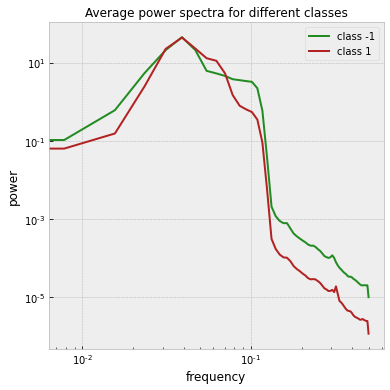

In [45]:
NUM_SAMPLES = 50

w_pos = w[(train.label==1)].mean(axis=0)
w_neg = w[(train.label==-1)].mean(axis=0)

plt.plot(f, w_neg, c="forestgreen", label="class -1")
plt.plot(f, w_pos, c="firebrick", label="class 1")

plt.legend(loc=0)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("frequency")
plt.ylabel("power")
plt.title("Average power spectra for different classes", fontsize=12);

Ok, we see that spectra are different for `1` and `-1`. How can we capture this as a feature?

Spectral entropy for the resque:

$$P(\omega) = |X(\omega)|^2$$
$$p(\omega) = \frac{P(\omega)} {\sum_\omega P(\omega)}$$
$$E = -\sum_\omega p(\omega) \ln p(\omega)$$

For more details, see, for example, [What is spectral entropy?](https://dsp.stackexchange.com/questions/23689/what-is-spectral-entropy) and [Spectral Entropy — An Underestimated Time Series Feature](https://towardsdatascience.com/spectral-entropy-an-underestimated-time-series-feature-94e18ae5b958).

In [46]:
p = w / w.sum(axis=1, keepdims=True)
train["entropy"] = - (p * np.log(p)).sum(axis=1)

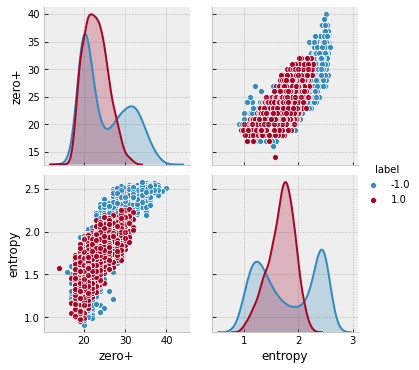

In [47]:
sns.pairplot(train[["label", "zero+", "entropy"]], hue="label");

Another idea is obvious from average spectra: low frequencies are more pronounced in class `-1`. Let's calculate ratio of spectral power in frequencies below, say, `5e-2`:

In [48]:
train["low_freq"] = p[:, f < 5e-2].sum(axis=1)

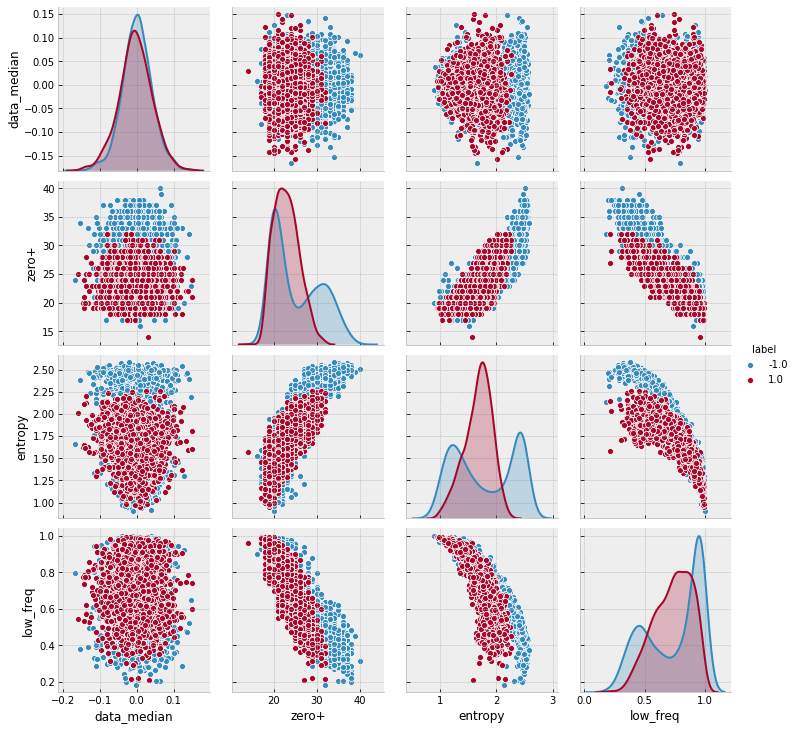

In [49]:
sns.pairplot(train[["label", "data_median", "zero+", "entropy", "low_freq"]], hue="label");

In [50]:
train.columns

Index(['label', 'val_1', 'val_2', 'val_3', 'val_4', 'val_5', 'val_6', 'val_7',
       'val_8', 'val_9',
       ...
       'val_500', 'data_median', 'data_skew', 'data_kurtosis', 'zero+',
       'diff_mean', 'diff_median', 'diff_std', 'entropy', 'low_freq'],
      dtype='object', length=510)

Let's to do some modeling and see if these features are enough. We'll keep the following features: `'data_median', 'data_skew', 'zero+', 'diff_std', 'entropy', 'low_freq'`.

# Task 4: modeling

Given all the features you selected in Tasks 2 and 3, create a binary  classification model. You need to perform:

- reasonable train/validation split of `train`,
- select a model type (out of those, available in `sklearn`, no need to go for, say, gradient boosting),
- train a model, validate it and calculate the final score (ROC AUC) for the test set.

## Solution

We saw, that features are highly nonlinear, hence. logistic regression we'll be of little help. Let's use random forest.

Since data is approximately balanced, we can use random split by samples (not by time because data is already sliced). We'll not do `k`-fold, although it may be helpful.

In [51]:
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

In [52]:
FTS_COLS = ['data_median', 'data_skew', 'zero+', 'diff_std', 'entropy', 'low_freq']

In [53]:
split = ShuffleSplit(n_splits=1, train_size=0.6, random_state=1764)
train_idx, val_idx = next(split.split(train[FTS_COLS]))

In [54]:
model = RandomForestClassifier(max_depth=2, n_estimators=16)
model.fit(train.iloc[train_idx][FTS_COLS], train.iloc[train_idx]["label"])

RandomForestClassifier(max_depth=2, n_estimators=16)

In [55]:
train_preds = model.predict(train.iloc[train_idx][FTS_COLS])
val_preds = model.predict(train.iloc[val_idx][FTS_COLS])

In [56]:
print("Training set classification report:\n")
print(classification_report(train.iloc[train_idx]["label"].values, train_preds))

Training set classification report:

              precision    recall  f1-score   support

        -1.0       0.85      0.78      0.81      1128
         1.0       0.78      0.85      0.81      1032

    accuracy                           0.81      2160
   macro avg       0.81      0.81      0.81      2160
weighted avg       0.82      0.81      0.81      2160



In [57]:
print("Validation set classification report:\n")
print(classification_report(train.iloc[val_idx]["label"].values, val_preds))

Validation set classification report:

              precision    recall  f1-score   support

        -1.0       0.84      0.76      0.80       718
         1.0       0.78      0.85      0.82       723

    accuracy                           0.81      1441
   macro avg       0.81      0.81      0.81      1441
weighted avg       0.81      0.81      0.81      1441



Ok, this is quite nice, we got F1 of about `0.82` out of nothing (6 features, tiny model).

Model like this can be created - after you polished time series skills a bit - in a matter of hour or two, and it's already meaningful. Moreover, training set and validation set performance is similar, and we expect test set performance to be similar as well.

Note: since the dataset is not exactly balanced, we see some difference between per-class precision and recall. This can be fixed by adjusting the threshold (i. e. use smth else instead of default `0.5` probability threshold which `model.predict` uses).

### Test set performance

We need to calculate `zero+`, `entropy`, `low_freq` for the test set.

In [58]:
test

,label,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,...,val_497,val_498,val_499,val_500,data_median,data_skew,data_kurtosis,diff_mean,diff_median,diff_std
0,-1.0,-0.140402,0.171641,0.302044,0.232804,0.033853,-0.224183,-0.469987,-0.645396,-0.617700,...,-0.049582,-0.690402,-0.976596,-0.794263,-0.001575,-0.120790,-0.066711,-0.001310,0.018926,0.413613
1,-1.0,0.334038,0.322253,0.453844,0.671852,0.887897,1.020469,1.059750,1.030290,0.950746,...,-1.041772,-1.041772,-1.159614,-1.375659,0.039186,-0.154661,-0.327427,-0.003426,-0.010017,0.409640
2,-1.0,0.716686,0.744367,0.725913,0.661325,0.555217,0.413585,0.246580,0.065273,-0.121109,...,-2.983269,-3.675281,-4.136622,-4.339612,0.015263,0.014113,5.180276,-0.010133,-0.009227,0.257795
3,1.0,1.240282,1.331189,1.386596,1.383220,1.305979,1.142784,0.878613,0.532291,0.140025,...,-1.011328,-0.931222,-0.934498,-1.001288,-0.016963,-0.055862,0.861376,-0.004492,0.012374,0.289362
4,-1.0,-1.159478,-1.204174,-1.167605,-1.033518,-0.818166,-0.558119,-0.299291,-0.093691,0.022770,...,-0.112382,0.008987,0.131413,0.186266,0.046735,-0.044763,-0.423170,0.002697,0.002438,0.265987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,-1.0,0.143630,-0.135823,-0.510278,-0.850804,-1.058080,-1.082756,-0.961845,-0.748399,-0.575669,...,1.761128,0.939424,-0.096588,-1.076587,-0.034776,0.118007,-0.624545,-0.002445,-0.004935,0.425804
1316,1.0,-0.165568,-0.504614,-0.780065,-0.937044,-0.950518,-0.854054,-0.701736,-0.544270,-0.424473,...,0.406564,1.100995,1.722323,2.191682,-0.059453,0.068962,-0.018028,0.004724,0.003575,0.307079
1317,1.0,0.710084,0.593979,0.381886,0.127285,-0.112304,-0.274140,-0.312698,-0.195008,0.063567,...,-0.192379,-0.126553,-0.117822,-0.189094,-0.018789,0.030349,-0.305147,-0.001802,-0.013832,0.353569
1318,1.0,0.006847,-0.140624,-0.270594,-0.378835,-0.461983,-0.515125,-0.538119,-0.532769,-0.495602,...,-0.870596,-1.000708,-1.084108,-1.109963,0.012554,0.022555,-0.696671,-0.002238,-0.008382,0.226547


In [59]:
mask = (test.filter(like="val_") > 0).astype(int)
test["zero+"] = (mask.diff(axis=1) == 1).sum(axis=1)

In [60]:
f, w = welch(test.filter(like="val_").values, nperseg=NPERSEG, fs=1)
print("Frequency shape:", f.shape)
print("Spectra shape:", w.shape)

Frequency shape: (65,)
Spectra shape: (1320, 65)


In [61]:
p = w / w.sum(axis=1, keepdims=True)
test["entropy"] = - (p * np.log(p)).sum(axis=1)
test["low_freq"] = p[:, f < 5e-2].sum(axis=1)

In [62]:
test_preds = model.predict(test[FTS_COLS])

In [63]:
print("Test set classification report:\n")
print(classification_report(test["label"].values, test_preds))

Test set classification report:

              precision    recall  f1-score   support

        -1.0       0.84      0.77      0.80       681
         1.0       0.77      0.84      0.81       639

    accuracy                           0.80      1320
   macro avg       0.80      0.80      0.80      1320
weighted avg       0.81      0.80      0.80      1320



As expected, test performance is similar to train and validation sets.

### Feature importances

Looking at scatter plots of different features, we expect some to be more important than others. Can we see this is feature importances?

In [64]:
pd.Series(model.feature_importances_, index=FTS_COLS).sort_values(ascending=False)

diff_std       0.325482
entropy        0.307549
low_freq       0.297930
zero+          0.057205
data_median    0.007302
data_skew      0.004533
dtype: float64